-=# Laboratory values vs outcome

Get the first laboratory measurements for patients admitted to the ICU. Plot the distribution of measurements for survival and non-survival groups.

In [5]:
# Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import yaml
import os

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# Load in merged GOSSIS data

In [6]:
df = pd.read_csv('gossis-data.csv',header=0,sep=",")
df['data_source'].value_counts()

C:\Python27\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,5,6,7,9,10,16,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


anzics       285807
eicu         130299
orchestra     59693
mimic         48660
Name: data_source, dtype: int64

# Load in the header and the data type for each column

In [7]:
hdr = pd.read_csv('hdr/header.csv',header=None,sep=',')[0].values

# load yaml definitions
with open("hdr/variable-definitions.yaml", 'r') as stream:
    try:
        varlist = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# convert to dataframe
df_var = pd.DataFrame.from_dict(varlist, orient='index')
df_var['varname'] = df_var.index

# specify the order of the categories - data is output in this order
category_order = {'identifier': 1,
                  'demographic': 2,
                  'APACHE covariate': 3,
                  'vitals': 4,
                  'labs': 5,
                  'labs blood gas': 6,
                  'APACHE prediction': 10}
df_var['category_order'] = df_var['category'].map(category_order)

# sort df by the category, then by the variable name
df_var.sort_values(['category_order','varname'],inplace=True)

In [8]:
df_var['category'].value_counts()

vitals               64
labs                 60
demographic          27
APACHE covariate     25
labs blood gas       16
identifier            4
APACHE prediction     4
Name: category, dtype: int64

In [9]:
df_var['dataType'].value_counts()

numeric    167
string      14
binary      11
integer      8
Name: dataType, dtype: int64

# Comparisons

For comparisons, we are interested assessing each variable across the databases.

For numeric/integer variables:

* Compare the mean, median, standard deviation, 5th and 95th percentiles
* Plot the distribution using histograms

For string/binary (categorical) variables:

* Compare the categories to see if they overlap
* Compare the frequency of each category (cross-tab)

## Compare readmissions

In [11]:
fac_list = ['elective_surgery','gender','icu_death','pregnant','readmission_status','smoking_status',
           'gcs_unable_apache','gcs_eyes_apache','gcs_motor_apache','gcs_verbal_apache','intubated_apache','ventilated_apache',
           'country','ethnicity','hospital_admit_source','hospital_disch_location','icu_admit_source',
           'icu_admit_type','icu_disch_location','icu_stay_type','icu_type','hospital_bed_size']

#bed size on eicu is a factor, but not the others

for a in fac_list:
    tbl = pd.crosstab(df[a], [df['hospital_death'],df['data_source']], margins = True)
    display(HTML(tbl.to_html().replace('NaN', '')))
    #get percentage table
    tbl_perc = tbl/tbl.xs('All', axis=0)
    display(HTML(tbl_perc.to_html()))

## Compare APACHE-III score in eicu and anzics patients

C:\Python27\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


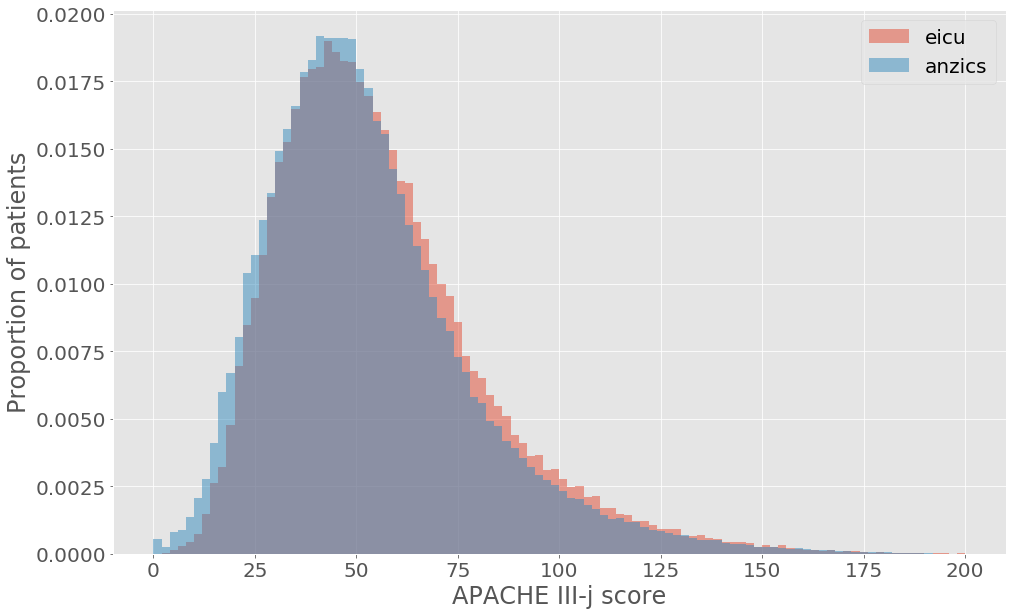

In [12]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
#plt.hist(df_all.loc[df_all['db']=='mimic','apsiii'].values, bins,
#         normed=True, alpha=0.5, label='mimic')
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.legend(loc='upper right')
plt.xlabel('APACHE III-j score')
plt.ylabel('Proportion of patients')
plt.show()

As we can see the distributions are very similar, though ANZICS seems to have lower acuity.

C:\Python27\lib\site-packages\matplotlib\axes\_axes.py:6198: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


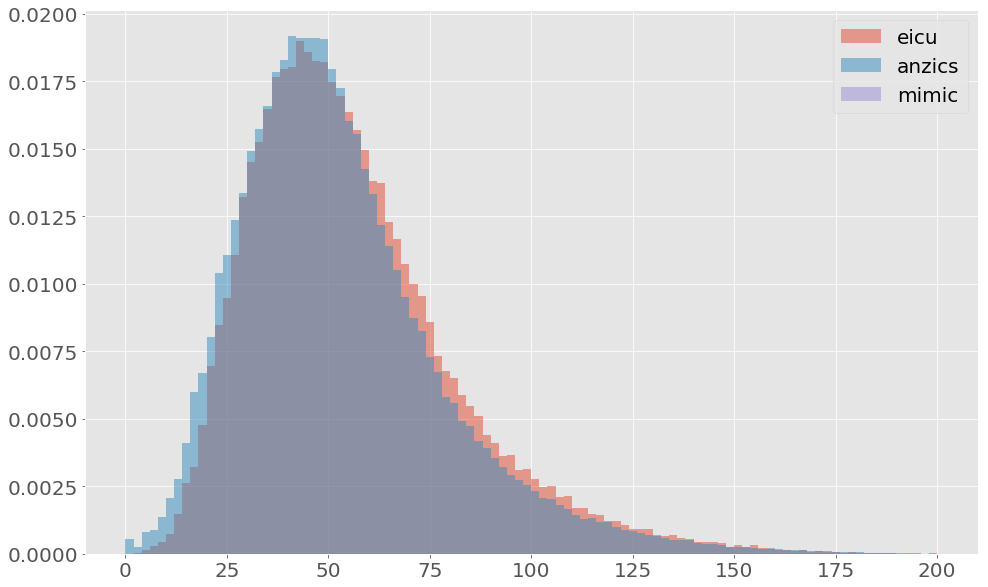

In [13]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
plt.rcParams.update({'font.size': 20})
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.hist(df.loc[df['data_source']=='mimic','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='mimic')
plt.legend(loc='upper right')
plt.show()

Note that we don't have any data for MIMIC for the APACHE-III score.

In [14]:
def stats(d, c, idx):
    avg_a = np.mean(df.loc[(df['data_source']=='anzics')&idx,c].dropna().values)
    avg_e = np.mean(df.loc[(df['data_source']=='eicu')&idx,c].dropna().values)
    avg_m = np.mean(df.loc[(df['data_source']=='mimic')&idx,c].dropna().values)
    avg_o = np.mean(df.loc[(df['data_source']=='orchestra')&idx,c].dropna().values)
    d[c+'_avg']= [avg_a, avg_e, avg_m, avg_o]
    std_a = np.std(df.loc[(df['data_source']=='anzics')&idx,c].dropna().values)
    std_e = np.std(df.loc[(df['data_source']=='eicu')&idx,c].dropna().values)
    std_m = np.std(df.loc[(df['data_source']=='mimic')&idx,c].dropna().values)
    std_o = np.std(df.loc[(df['data_source']=='orchestra')&idx,c].dropna().values)
    d[c+'_std']= [std_a, std_e, std_m, std_o]
    med_a = np.median(df.loc[(df['data_source']=='anzics')&idx,c].dropna().values)
    med_e = np.median(df.loc[(df['data_source']=='eicu')&idx,c].dropna().values)
    med_m = np.median(df.loc[(df['data_source']=='mimic')&idx,c].dropna().values)
    med_o = np.median(df.loc[(df['data_source']=='orchestra')&idx,c].dropna().values)
    d[c+'_med']= [med_a, med_e, med_m, med_o]
    return d, [avg_a,avg_e,avg_m,avg_o]

In [15]:
from scipy.signal import medfilt

#hospital_los_days has '#REF!' under orchestra
cont = ['age','bmi','height','icu_los_days','pre_icu_los_days','weight',
       'albumin_apache','arf_apache','bilirubin_apache','bun_apache','creatinine_apache','fio2_apache','glucose_apache',
       'heart_rate_apache','hematocrit_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache', 'ph_apache',
       'resprate_apache','sodium_apache','temp_apache','urineoutput_apache','wbc_apache','d1_diasbp_invasive_max',
       'd1_diasbp_invasive_min','d1_diasbp_max','d1_diasbp_min','d1_diasbp_noninvasive_max','d1_diasbp_noninvasive_min',
       'd1_heartrate_max','d1_heartrate_min','d1_mbp_invasive_max','d1_mbp_invasive_min','d1_mbp_max','d1_mbp_min',
       'd1_mbp_noninvasive_max','d1_mbp_noninvasive_min','d1_resprate_max','d1_resprate_min','d1_spo2_max','d1_spo2_min',
       'd1_sysbp_invasive_max','d1_sysbp_invasive_min','d1_sysbp_max','d1_sysbp_min','d1_sysbp_noninvasive_max',
       'd1_sysbp_noninvasive_min','d1_temp_max','d1_temp_min','h1_diasbp_invasive_max','h1_diasbp_invasive_min',
       'h1_diasbp_max','h1_diasbp_min','h1_diasbp_noninvasive_max','h1_diasbp_noninvasive_min','h1_heartrate_max',
       'h1_heartrate_min','h1_mbp_invasive_max','h1_mbp_invasive_min','h1_mbp_max','h1_mbp_min','h1_mbp_noninvasive_max',
       'h1_mbp_noninvasive_min','h1_resprate_max','h1_resprate_min','h1_spo2_max','h1_spo2_min','h1_sysbp_invasive_max',
       'h1_sysbp_invasive_min','h1_sysbp_max','h1_sysbp_min','h1_sysbp_noninvasive_max','h1_sysbp_noninvasive_min',
       'h1_temp_max','h1_temp_min','d1_albumin_max','d1_albumin_min','d1_bilirubin_max','d1_bilirubin_min','d1_bun_max',
       'd1_bun_min','d1_calcium_max','d1_calcium_min','d1_creatinine_max','d1_creatinine_min','d1_glucose_max','d1_glucose_min',
       'd1_hco3_max','d1_hco3_min','d1_hemaglobin_max','d1_hemaglobin_min','d1_hematocrit_max','d1_hematocrit_min',
       'd1_inr_max','d1_inr_min','d1_lactate_max','d1_lactate_min','d1_platelets_max','d1_platelets_min','d1_potassium_max',
       'd1_potassium_min','d1_sodium_max','d1_sodium_min','d1_wbc_max','d1_wbc_min','h1_albumin_max','h1_albumin_min',
       'h1_bilirubin_max','h1_bilirubin_min','h1_bun_max','h1_bun_min','h1_calcium_max','h1_calcium_min','h1_creatinine_max',
       'h1_creatinine_min','h1_glucose_max','h1_glucose_min','h1_hco3_max','h1_hco3_min','h1_hemaglobin_max','h1_hemaglobin_min',
       'h1_hematocrit_max','h1_hematocrit_min','h1_inr_max','h1_inr_min','h1_lactate_max','h1_lactate_min','h1_platelets_max',
       'h1_platelets_min','h1_potassium_max','h1_potassium_min','h1_sodium_max','h1_sodium_min','h1_wbc_max','h1_wbc_min',
       'd1_arterial_pco2_max','d1_arterial_pco2_min','d1_arterial_ph_max','d1_arterial_ph_min','d1_arterial_po2_max',
       'd1_arterial_po2_min','d1_pao2fio2ratio_min','h1_arterial_pco2_max','h1_arterial_pco2_min','h1_arterial_ph_max',
        'h1_arterial_ph_min','h1_arterial_po2_max','h1_arterial_po2_min','h1_pao2fio2ratio_max','h1_pao2fio2ratio_min',
       'apache_3j_score']

tb_header = ['anzics','eicu','mimic','orchestra']
d = {}
d_alive = {}
d_death = {}

for c in cont:
    idx = df['hospital_death']==0
    d_alive, trash = stats(d_alive, c, idx)
    idx = df['hospital_death']==1
    d_death, trash = stats(d_death, c, idx) 
    idx = df['hospital_death'] < 2
    d,[avg_a,avg_e,avg_m,avg_o] = stats(d, c, idx)
    
    # create a histogram of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    bins = np.linspace( df.loc[:,c].dropna().quantile(0.01), df.loc[:,c].dropna().quantile(0.99), 51 )
    
    if avg_e is np.nan:
        # no data
        binned_e = [0,0]
        bins_e = [0,0]
        lbl_e = 'eicu (no data)'
        plt.plot(binned_e, bins_e, 'o', label=lbl_e)
    else:
        lbl_e = 'eicu'
        binned_e,bins_e,patches_e = plt.hist(df.loc[df['data_source']=='eicu',c].dropna().values,
                                                      bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                      label=lbl_e)
        
    if avg_a is np.nan:
        # no data
        binned_a = [0,0]
        bins_a = [0,0]
        lbl_a = 'anzics (no data)'
        plt.plot(binned_a, bins_a, 'o', label=lbl_a)
    else:
        lbl_a = 'anzics'
        binned_a,bins_a,patches_a = plt.hist(df.loc[df['data_source']=='anzics',c].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_a) 
    if avg_m is np.nan:
        # no data
        binned_m = [0,0]
        bins_m = [0,0]
        lbl_m = 'mimic (no data)'
        plt.plot(binned_m, bins_m, 'o', label=lbl_m)
    else:
        lbl_m = 'mimic'
        binned_m,bins_m,patches_m = plt.hist(df.loc[df['data_source']=='mimic',c].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_m)
    if avg_o is np.nan:
        # no data
        binned_o = [0,0]
        bins_o = [0,0]
        lbl_o = 'orchestra (no data)'
        plt.plot(binned_o, bins_o, 'o', label=lbl_o)
    else:
        lbl_o = 'orchestra'
        binned_o,bins_o,patches_o = plt.hist(df.loc[df['data_source']=='orchestra',c].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_o)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','hist',c+'.png'))
    plt.close()
    
    # just plot a line plot of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    plt.plot(bins_e[0:-1] + (bins_e[1]-bins_e[0])/2.0, medfilt(binned_e,3), '-', lw=2, alpha=0.5, label=lbl_e)
    plt.plot(bins_a[0:-1] + (bins_a[1]-bins_a[0])/2.0, medfilt(binned_a,3), '-', lw=2, alpha=0.5, label=lbl_a) 
    plt.plot(bins_m[0:-1] + (bins_m[1]-bins_m[0])/2.0, medfilt(binned_m,3), '-', lw=2, alpha=0.5, label=lbl_m)
    plt.plot(bins_o[0:-1] + (bins_o[1]-bins_o[0])/2.0, medfilt(binned_o,3), '-', lw=2, alpha=0.5, label=lbl_o)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results',c+'.png'))
    plt.close()
    
print('done')

C:\Python27\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Python27\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Python27\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Python27\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Python27\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done


# All patients table

In [16]:
tb = pd.DataFrame(d, index=tb_header)
tb=tb.transpose()
display(HTML(tb.to_html().replace('NaN', '')))

,anzics,eicu,mimic,orchestra
age_avg,60.420791,62.078115,74.834305,62.331245
age_med,64.400000,64.000000,65.688000,65.000000
age_std,19.391007,16.577414,55.151000,19.327434
albumin_apache_avg,3.005180,2.895859,3.205178,
albumin_apache_med,3.000000,2.900000,3.200000,
albumin_apache_std,0.641370,0.690841,0.733821,
apache_3j_score_avg,52.635810,55.499781,,
apache_3j_score_med,48.000000,51.000000,,
apache_3j_score_std,25.487398,25.595483,,
arf_apache_avg,0.047336,0.036623,,


# Survivors table

In [17]:
tb = pd.DataFrame(d_alive, index=tb_header)
tb=tb.transpose()
display(HTML(tb.to_html().replace('NaN', '')))

,anzics,eicu,mimic,orchestra
age_avg,59.747904,61.502264,72.878616,61.007748
age_med,63.700000,64.000000,64.705000,63.000000
age_std,19.518812,16.664235,52.741509,19.305857
albumin_apache_avg,3.030777,2.947340,3.271904,
albumin_apache_med,3.000000,3.000000,3.300000,
albumin_apache_std,0.630385,0.673060,0.710056,
apache_3j_score_avg,49.212072,52.195929,,
apache_3j_score_med,47.000000,49.000000,,
apache_3j_score_std,21.831249,22.313979,,
arf_apache_avg,0.034496,0.035292,,


# Patients that passed away

In [18]:
tb = pd.DataFrame(d_death, index=tb_header)
tb=tb.transpose()
display(HTML(tb.to_html().replace('NaN', '')))

,anzics,eicu,mimic,orchestra
age_avg,67.973818,67.980055,90.362318,70.214544
age_med,70.800000,70.000000,73.819500,73.000000
age_std,16.064276,14.387481,69.528814,17.490997
albumin_apache_avg,2.722166,2.516324,2.863076,
albumin_apache_med,2.700000,2.500000,2.900000,
albumin_apache_std,0.691721,0.701761,0.757997,
apache_3j_score_avg,90.681592,88.235161,,
apache_3j_score_med,87.000000,84.000000,,
apache_3j_score_std,31.533304,32.141825,,
arf_apache_avg,0.191347,0.049812,,


In [19]:
tb.to_csv('gossis-stats.csv',index=True)

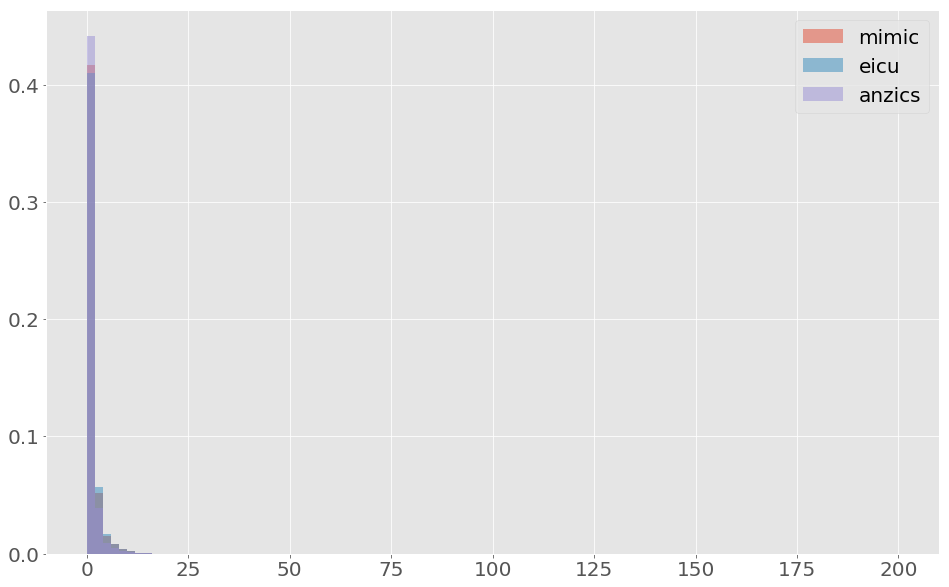

In [20]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
plt.hist(df.loc[df['data_source']=='mimic','d1_creatinine_max'].dropna().values, bins,
         normed=True, alpha=0.5, label='mimic')
plt.hist(df.loc[df['data_source']=='eicu','d1_creatinine_max'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','d1_creatinine_max'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.legend(loc='upper right')
plt.show()

# Day 1 vs Hour 1

In [21]:
d1_h1=['arterial_pco2_max', 'arterial_pco2_min', 'arterial_ph_max', 'arterial_ph_min', 'arterial_po2_max', 'arterial_po2_min', 
       'bilirubin_max', 'creatinine_max', 'diasbp_min', 'heartrate_max', 'lactate_max', 'mbp_min', 'pao2fio2ratio_max', 
       'pao2fio2ratio_min', 'platelets_min', 'resprate_max', 'sysbp_min', 'temp_max', 'wbc_max']
if not os.path.exists(os.path.join('results','d1_h1')):
    os.makedirs(os.path.join('results','d1_h1'))
for dh in d1_h1:
    # just plot a line plot of the data
    plt.figure(figsize=[16,10])
    plt.hist(df.loc[df['data_source']=='mimic','d1_'+dh].dropna().values,
             normed=True, alpha=0.5, label='mimic_d1')
    plt.hist(df.loc[df['data_source']=='eicu','d1_'+dh].dropna().values, bins,
             normed=True, alpha=0.5, label='eicu_d1')
    plt.hist(df.loc[df['data_source']=='mimic','h1_'+dh].dropna().values, bins,
             normed=True, alpha=0.5, label='mimic_h1')
    plt.hist(df.loc[df['data_source']=='eicu','h1_'+dh].dropna().values, bins,
             normed=True, alpha=0.5, label='eicu_h1')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','d1_h1',dh+'.png'))
    plt.close()
    
header = ['eicu_d1','eicu_h1','mimic_d1','mimic_h1', 'orchestra']
hd = {}

for dh in d1_h1:
    avg_a = np.mean(df.loc[(df['data_source']=='eicu')&idx,'d1_'+dh].dropna().values)
    avg_e = np.mean(df.loc[(df['data_source']=='eicu')&idx,'h1_'+dh].dropna().values)
    avg_m = np.mean(df.loc[(df['data_source']=='mimic')&idx,'d1_'+dh].dropna().values)
    avg_o = np.mean(df.loc[(df['data_source']=='mimic')&idx,'h1_'+dh].dropna().values)
    avg_t = np.mean(df.loc[(df['data_source']=='orchestra')&idx,'h1_'+dh].dropna().values)
    hd[dh+'_avg']= [avg_a, avg_e, avg_m, avg_o, avg_t]
    std_a = np.std(df.loc[(df['data_source']=='eicu')&idx,'d1_'+dh].dropna().values)
    std_e = np.std(df.loc[(df['data_source']=='eicu')&idx,'h1_'+dh].dropna().values)
    std_m = np.std(df.loc[(df['data_source']=='mimic')&idx,'d1_'+dh].dropna().values)
    std_o = np.std(df.loc[(df['data_source']=='mimic')&idx,'h1_'+dh].dropna().values)
    std_t = np.std(df.loc[(df['data_source']=='orchestra')&idx,'h1_'+dh].dropna().values)
    hd[dh+'_std']= [std_a, std_e, std_m, std_o, std_t]
    med_a = np.median(df.loc[(df['data_source']=='eicu')&idx,'d1_'+dh].dropna().values)
    med_e = np.median(df.loc[(df['data_source']=='eicu')&idx,'h1_'+dh].dropna().values)
    med_m = np.median(df.loc[(df['data_source']=='mimic')&idx,'d1_'+dh].dropna().values)
    med_o = np.median(df.loc[(df['data_source']=='mimic')&idx,'h1_'+dh].dropna().values)
    med_t = np.median(df.loc[(df['data_source']=='orchestra')&idx,'h1_'+dh].dropna().values)
    hd[dh+'_med']= [med_a, med_e, med_m, med_o, med_t]
    
    # create a histogram of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    bins = np.linspace( df.loc[:,'h1_'+dh].dropna().quantile(0.01), df.loc[:,'h1_'+dh].dropna().quantile(0.99), 51 )
    
    if avg_e is np.nan:
        # no data
        binned_e = [0,0]
        bins_e = [0,0]
        lbl_e = 'eicu_h1 (no data)'
        plt.plot(binned_e, bins_e, 'o', label=lbl_e)
    else:
        lbl_e = 'eicu_h1'
        binned_e,bins_e,patches_e = plt.hist(df.loc[df['data_source']=='eicu','h1_'+dh].dropna().values,
                                                      bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                      label=lbl_e)
        
    if avg_a is np.nan:
        # no data
        binned_a = [0,0]
        bins_a = [0,0]
        lbl_a = 'eicu_d1 (no data)'
        plt.plot(binned_a, bins_a, 'o', label=lbl_a)
    else:
        lbl_a = 'eicu_d1'
        binned_a,bins_a,patches_a = plt.hist(df.loc[df['data_source']=='eicu','d1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_a) 
    if avg_m is np.nan:
        # no data
        binned_m = [0,0]
        bins_m = [0,0]
        lbl_m = 'mimic_d1 (no data)'
        plt.plot(binned_m, bins_m, 'o', label=lbl_m)
    else:
        lbl_m = 'mimic_d1'
        binned_m,bins_m,patches_m = plt.hist(df.loc[df['data_source']=='mimic','d1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_m)
    if avg_o is np.nan:
        # no data
        binned_o = [0,0]
        bins_o = [0,0]
        lbl_o = 'mimic_h1 (no data)'
        plt.plot(binned_o, bins_o, 'o', label=lbl_o)
    else:
        lbl_o = 'mimic_h1'
        binned_o,bins_o,patches_o = plt.hist(df.loc[df['data_source']=='mimic','h1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_o)
    lbl_t = 'orchestra_h1'
    binned_t,bins_t,patches_t = plt.hist(df.loc[df['data_source']=='orchestra','h1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_t)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','d1_h1',dh+'_his.png'))
    plt.close()
    
    # just plot a line plot of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    plt.plot(bins_e[0:-1] + (bins_e[1]-bins_e[0])/2.0, medfilt(binned_e,3), '-', lw=2, alpha=0.5, label=lbl_e)
    plt.plot(bins_a[0:-1] + (bins_a[1]-bins_a[0])/2.0, medfilt(binned_a,3), '-', lw=2, alpha=0.5, label=lbl_a) 
    plt.plot(bins_m[0:-1] + (bins_m[1]-bins_m[0])/2.0, medfilt(binned_m,3), '-', lw=2, alpha=0.5, label=lbl_m)
    plt.plot(bins_o[0:-1] + (bins_o[1]-bins_o[0])/2.0, medfilt(binned_o,3), '-', lw=2, alpha=0.5, label=lbl_o)
    plt.plot(bins_t[0:-1] + (bins_t[1]-bins_t[0])/2.0, medfilt(binned_t,3), '-', lw=2, alpha=0.5, label=lbl_t)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','d1_h1',dh+'.png'))
    plt.close()
    
tb = pd.DataFrame(hd, index=header)
tb=tb.transpose()
display(HTML(tb.to_html().replace('NaN', '')))

,eicu_d1,eicu_h1,mimic_d1,mimic_h1,orchestra
arterial_pco2_max_avg,47.424435,47.091562,47.136818,44.441357,38.603498
arterial_pco2_max_med,44.000000,44.000000,45.000000,42.000000,37.000000
arterial_pco2_max_std,17.554496,18.215929,13.406921,12.570400,12.475641
arterial_pco2_min_avg,38.588274,42.645547,36.744201,41.751573,36.318192
arterial_pco2_min_med,37.000000,39.000000,35.000000,40.000000,35.250000
arterial_pco2_min_std,12.077591,15.862959,9.496664,12.069895,11.647419
arterial_ph_max_avg,7.406635,7.356073,7.420357,7.374794,7.377198
arterial_ph_max_med,7.400000,7.370000,7.420000,7.390000,7.390000
arterial_ph_max_std,3.027988,0.116485,0.073063,0.098529,0.092652
arterial_ph_min_avg,7.324767,7.316939,7.325160,7.350263,7.348691
